In [1]:
# for data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Data Analysis
Summarize the characteristics of the dataset.

In [2]:
query_data = QueryData(update=True)
clean_data = CleanData()
helpers = Helpers()

# pull boxscore data
boxscores = query_data.query_boxscore_data()
boxscores = clean_data.select_regular_season_games(boxscores)
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


AttributeError: 'CleanData' object has no attribute 'select_regular_season_games'

In [3]:
display(boxscores)

,GAMEID,PLAYERID,TEAM,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,POSS,TOTAL_ATTEMPTS,TOTAL_PTS,TOTAL_FTA,TOTAL_FTM,SHOT_ATTEMPTS,SHOT_PTS,SHOT_FTA,SHOT_FTM,SFOUL_ATTEMPTS,SFOUL_PTS,SFOUL_FTA,SFOUL_FTM,PFOUL_ATTEMPTS,PFOUL_PTS,PFOUL_FTA,PFOUL_FTM,TFOUL_ATTEMPTS,TFOUL_PTS,TFOUL_FTA,TFOUL_FTM,ID,SEASON,SEASONTYPE,DATE,HTM,VTM,W
0,0011400001,2365,MIA,NOP,DNP - Coach's Decision,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.0,0,0.000,0.0,0.000,0,0.000,0.0,0,0,0,0,0,0.000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0011400001,2014-15,Pre Season,2014-10-04,MIA,NOP,NOP
1,0011400001,2422,NOP,MIA,,0,363,3,1,2,1,1,0,0,0,0,0,0,0.00,1.0,0,0.000,1.0,0.200,0,0.000,0.0,0,0,0,1,-9,0.154,103.14,12,2,3,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0011400001,2014-15,Pre Season,2014-10-04,MIA,NOP,NOP
2,0011400001,2547,MIA,NOP,,1,1520,9,3,13,1,3,2,3,0,3,0,4,1.00,0.0,1,0.036,5.0,0.227,2,0.200,10.0,1,0,4,2,-10,0.327,96.63,51,14,9,3,2,13,8,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0011400001,2014-15,Pre Season,2014-10-04,MIA,NOP,NOP
3,0011400001,2548,MIA,NOP,,1,1231,6,2,7,0,1,2,4,0,0,0,0,0.50,0.0,0,0.000,2.0,0.133,3,0.333,23.1,0,0,1,1,-11,0.222,97.09,41,9,6,4,2,7,4,0,0,2,2,4,2,0,0,0,0,0,0,0,0,0011400001,2014-15,Pre Season,2014-10-04,MIA,NOP,NOP
4,0011400001,2617,MIA,NOP,,1,632,2,1,2,0,1,0,0,0,0,0,0,1.00,0.0,0,0.000,2.0,0.222,1,0.333,33.3,1,0,0,2,-8,0.087,102.53,22,2,2,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0011400001,2014-15,Pre Season,2014-10-04,MIA,NOP,NOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222877,0022000677,1630168,ATL,SAC,,0,208,0,0,0,0,0,0,0,0,0,0,0,0.00,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,2,0.000,103.85,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0022000677,2020-21,Regular Season,2021-03-24,SAC,ATL,SAC
222878,0022000677,1630169,SAC,ATL,,1,2133,17,6,12,2,4,3,3,2,0,0,6,0.25,0.0,1,0.026,4.0,0.118,7,0.280,29.2,1,1,4,1,0,0.198,98.57,74,13,17,3,3,12,15,1,1,1,2,2,2,0,0,0,0,0,0,0,0,0022000677,2020-21,Regular Season,2021-03-24,SAC,ATL,SAC
222879,0022000677,1630218,SAC,ATL,DNP - Coach's Decision,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.0,0,0.000,0.0,0.000,0,0.000,0.0,0,0,0,0,0,0.000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0022000677,2020-21,Regular Season,2021-03-24,SAC,ATL,SAC
222880,0022000677,1630219,ATL,SAC,DNP - Coach's Decision,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.0,0,0.000,0.0,0.000,0,0.000,0.0,0,0,0,0,0,0.000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0022000677,2020-21,Regular Season,2021-03-24,SAC,ATL,SAC


In [2]:
query_data = QueryData()
clean_data = CleanData()

boxscores = query_data.query_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [5]:
display(boxscores.loc[boxscores['PTS'] > 69])

,GAMEID,PLAYERID,TEAM,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,POSS,TOTAL_ATTEMPTS,TOTAL_PTS,TOTAL_FTA,TOTAL_FTM,SHOT_ATTEMPTS,SHOT_PTS,SHOT_FTA,SHOT_FTM,SFOUL_ATTEMPTS,SFOUL_PTS,SFOUL_FTA,SFOUL_FTM,PFOUL_ATTEMPTS,PFOUL_PTS,PFOUL_FTA,PFOUL_FTM,TFOUL_ATTEMPTS,TFOUL_PTS,TFOUL_FTA,TFOUL_FTM,ID,SEASON,SEASONTYPE,DATE,HTM,VTM,W
112444,0021601076,1626164,PHX,BOS,,1,2698,70,21,40,4,11,24,26,17,4,15,18,0.353,0.75,2,0.039,6.0,0.111,6,0.375,9.8,3,1,5,3,-6,0.474,111.02,104,53,70,26,24,40,48,2,2,10,17,18,17,3,5,6,5,0,0,0,0,0021601076,2016-17,Regular Season,2017-03-24,BOS,PHX,PHX


In [3]:
q_boxscores = query_data.query_quarterly_boxscore_data()
q_boxscores = q_boxscores.pivot_table('SECONDSPLAYED', ['GAMEID', 'PLAYERID'], 'QUARTER')
q_boxscores.columns =['SP(Q{})'.format(str(col)) for col in q_boxscores.columns]

In [4]:
boxscores = boxscores.merge(q_boxscores, on=['GAMEID', 'PLAYERID'], how='left')
boxscores[q_boxscores.columns] = boxscores[q_boxscores.columns].fillna(0)

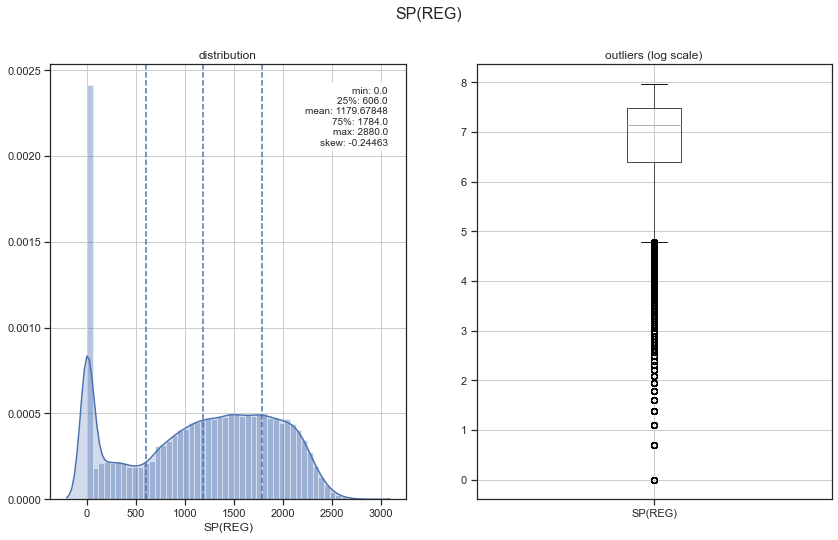

In [5]:
boxscores['SP(REG)'] = boxscores['SP(Q1)'] + boxscores['SP(Q2)'] + boxscores['SP(Q3)'] + boxscores['SP(Q4)']
helpers.visualize_variable_distribution(boxscores, 'SP(REG)', figsize=(14, 8))

# Feature Engineering
Create new features from raw data using domain knowlege.

In [6]:
y = 'SP(REG)'
regressors = []

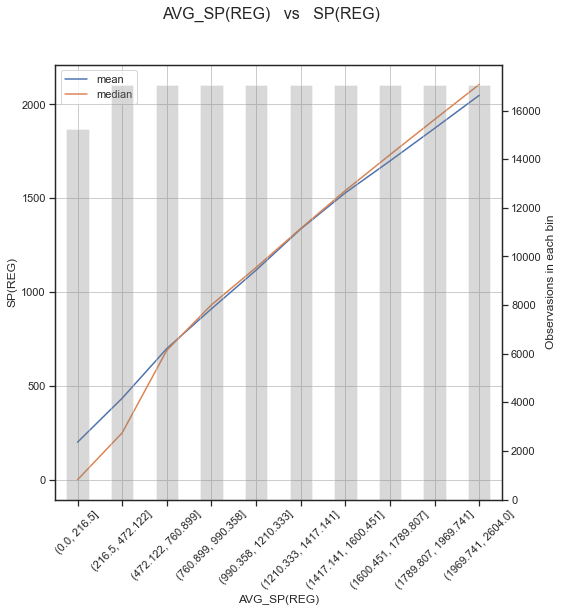

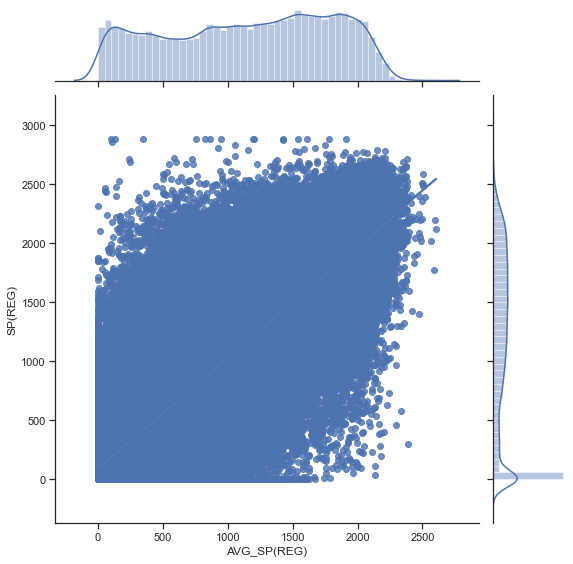

In [7]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='AVG_SP(REG)'
)
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_SP(REG)', 'SP(REG)', figsize=(8, 8))
regressors.append('AVG_SP(REG)')

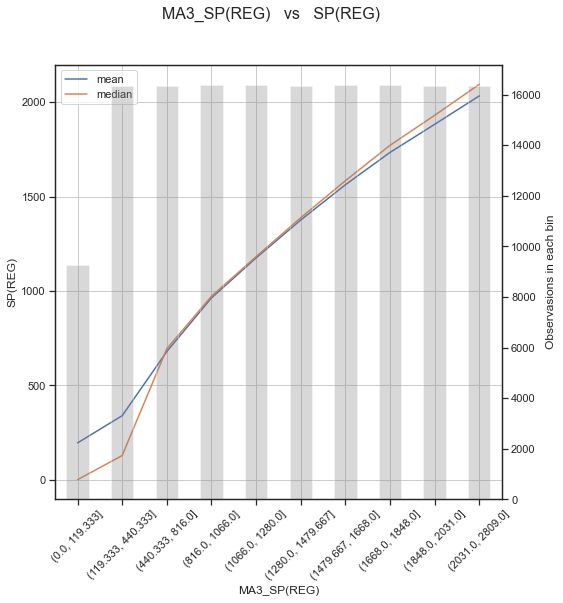

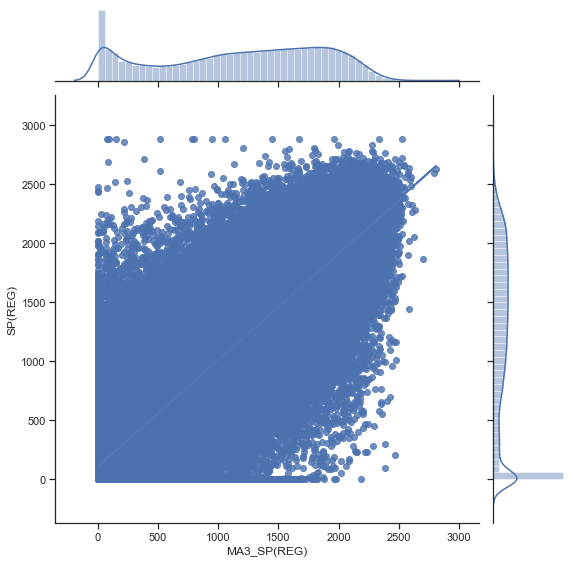

In [8]:
boxscores = feature_creation.rolling_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='MA3_SP(REG)',
    n_rolling=3, min_periods=2
)
helpers.visualize_numeric_x_vs_y(boxscores, 'MA3_SP(REG)', 'SP(REG)', figsize=(8, 8))
regressors.append('MA3_SP(REG)')

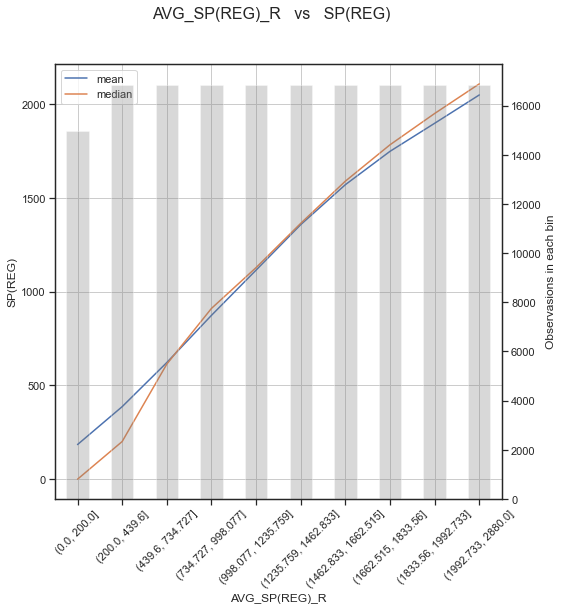

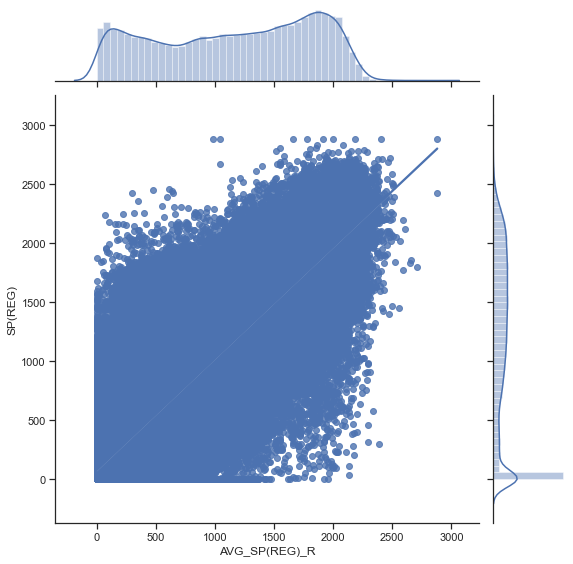

In [9]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='SP(REG)', new_col_name='AVG_SP(REG)_R'
)
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_SP(REG)_R', 'SP(REG)', figsize=(8, 8))
regressors.append('AVG_SP(REG)_R')

In [10]:
temp = boxscores.dropna(subset=['AVG_SP(REG)'])
temp = temp.groupby(['GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'SUM_AVG_SP(REG)': x['AVG_SP(REG)'].sum()
    })
)
boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
regressors.append('SUM_AVG_SP(REG)')

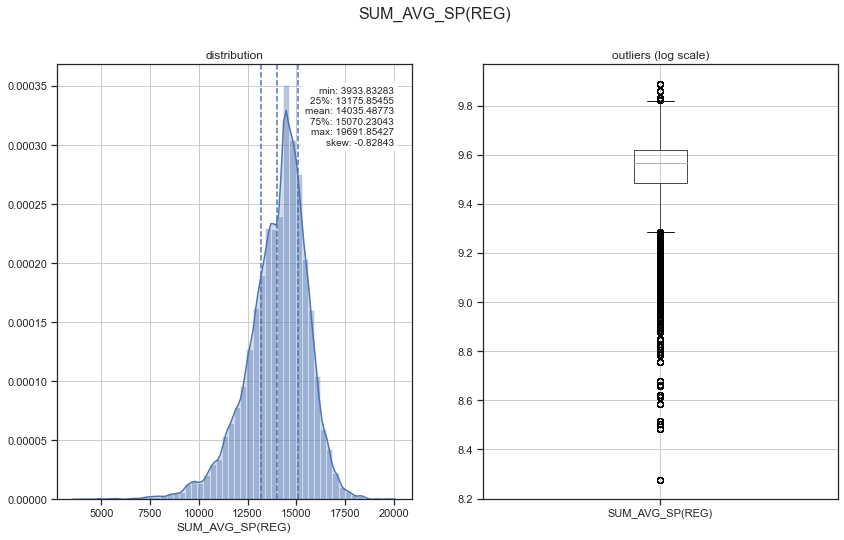

In [11]:
helpers.visualize_variable_distribution(boxscores, 'SUM_AVG_SP(REG)', figsize=(14, 8))

### Blowout Risk
Next, I will create features that capture the blowout risk in a game.

In [12]:
odds = query_data.query_odds_data()
odds['POINTSPREAD'] = odds['POINTSPREAD'].replace(['PK', '-'], 0)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

2020-08-09 []
2020-08-03 []
2020-08-10 []
2020-08-06 []
2020-08-07 []
2020-08-11 []
2020-08-05 []
2020-08-02 []
2020-07-31 []
2020-08-01 []
2020-08-04 []
2020-07-30 []
2020-08-12 []
2020-08-08 []
2020-08-14 []
2020-08-13 []


In [13]:
boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')
regressors.append('POINTSPREAD')

### Weights
TODO

In [14]:
w = 'WEIGHT'
boxscores[w] = 1

# STARTER MODEL

In [15]:
start_boxscores = boxscores.loc[boxscores['START'] == 1]

feature_matrix = start_boxscores[['GAMEID', 'PLAYERID'] + regressors + [y] + [w]]
feature_matrix = feature_matrix.dropna(subset=['AVG_SP(REG)'])
feature_matrix['MA3_SP(REG)'] = feature_matrix['MA3_SP(REG)'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['AVG_SP(REG)_R'] = feature_matrix['AVG_SP(REG)_R'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['POINTSPREAD'] = feature_matrix['POINTSPREAD'].fillna(0)

selected_features = regressors
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [16]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['RMSE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 10,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 405.8660424	test: 406.9815908	best: 406.9815908 (0)	total: 65.1ms	remaining: 5m 25s
1:	learn: 399.5804212	test: 400.7882608	best: 400.7882608 (1)	total: 76.5ms	remaining: 3m 11s
2:	learn: 393.8210791	test: 395.1010898	best: 395.1010898 (2)	total: 85.7ms	remaining: 2m 22s
3:	learn: 388.6250337	test: 390.0337634	best: 390.0337634 (3)	total: 92.2ms	remaining: 1m 55s
4:	learn: 383.6838055	test: 385.1668325	best: 385.1668325 (4)	total: 97.8ms	remaining: 1m 37s
5:	learn: 379.1652134	test: 380.7014281	best: 380.7014281 (5)	total: 104ms	remaining: 1m 26s
6:	learn: 375.0524254	test: 376.7003873	best: 376.7003873 (6)	total: 119ms	remaining: 1m 24s
7:	learn: 371.2657263	test: 372.9951063	best: 372.9951063 (7)	total: 127ms	remaining: 1m 19s
8:	learn: 367.7724392	test: 369.5869217	best: 369.5869217 (8)	total: 133ms	remaining: 1m 13s
9:	learn: 364.5466807	test: 366.4291722	best: 366.4291722 (9)	total: 138ms	remaining: 1m 9s
10:	learn: 361.5896365	test: 363.5256138	best: 363.5256138 (10)	to

89:	learn: 326.6413539	test: 331.0311354	best: 331.0311354 (89)	total: 661ms	remaining: 36.1s
90:	learn: 326.5954832	test: 331.0160362	best: 331.0160362 (90)	total: 667ms	remaining: 36s
91:	learn: 326.5451243	test: 331.0050465	best: 331.0050465 (91)	total: 673ms	remaining: 35.9s
92:	learn: 326.5049961	test: 330.9998202	best: 330.9998202 (92)	total: 678ms	remaining: 35.8s
93:	learn: 326.4669485	test: 330.9877708	best: 330.9877708 (93)	total: 686ms	remaining: 35.8s
94:	learn: 326.4296248	test: 330.9818183	best: 330.9818183 (94)	total: 692ms	remaining: 35.7s
95:	learn: 326.3784619	test: 330.9579243	best: 330.9579243 (95)	total: 697ms	remaining: 35.6s
96:	learn: 326.3520856	test: 330.9442026	best: 330.9442026 (96)	total: 703ms	remaining: 35.5s
97:	learn: 326.3117811	test: 330.9381747	best: 330.9381747 (97)	total: 709ms	remaining: 35.4s
98:	learn: 326.2629783	test: 330.9118625	best: 330.9118625 (98)	total: 714ms	remaining: 35.4s
99:	learn: 326.2188004	test: 330.8976441	best: 330.8976441 (99

In [17]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 405.8660424	test: 406.9815908	best: 406.9815908 (0)	total: 9.66ms	remaining: 48.3s
1:	learn: 399.5804212	test: 400.7882608	best: 400.7882608 (1)	total: 15.8ms	remaining: 39.6s
2:	learn: 393.8210791	test: 395.1010898	best: 395.1010898 (2)	total: 21.8ms	remaining: 36.2s
3:	learn: 388.6250337	test: 390.0337634	best: 390.0337634 (3)	total: 27.6ms	remaining: 34.5s
4:	learn: 383.6838055	test: 385.1668325	best: 385.1668325 (4)	total: 33.9ms	remaining: 33.9s
5:	learn: 379.1652134	test: 380.7014281	best: 380.7014281 (5)	total: 39.5ms	remaining: 32.9s
6:	learn: 375.0524254	test: 376.7003873	best: 376.7003873 (6)	total: 45.4ms	remaining: 32.4s
7:	learn: 371.2657263	test: 372.9951063	best: 372.9951063 (7)	total: 51.1ms	remaining: 31.9s
8:	learn: 367.7724392	test: 369.5869217	best: 369.5869217 (8)	total: 58ms	remaining: 32.2s
9:	learn: 364.5466807	test: 366.4291722	best: 366.4291722 (9)	total: 64.7ms	remaining: 32.3s
10:	learn: 361.5896365	test: 363.5256138	best: 363.5256138 (10)	total: 7

95:	learn: 326.3784619	test: 330.9579243	best: 330.9579243 (95)	total: 1.03s	remaining: 52.4s
96:	learn: 326.3520856	test: 330.9442026	best: 330.9442026 (96)	total: 1.04s	remaining: 52.4s
97:	learn: 326.3117811	test: 330.9381747	best: 330.9381747 (97)	total: 1.04s	remaining: 52.2s
98:	learn: 326.2629783	test: 330.9118625	best: 330.9118625 (98)	total: 1.05s	remaining: 52.2s
99:	learn: 326.2188004	test: 330.8976441	best: 330.8976441 (99)	total: 1.06s	remaining: 52.1s
100:	learn: 326.1827628	test: 330.8877394	best: 330.8877394 (100)	total: 1.08s	remaining: 52.2s
101:	learn: 326.1560625	test: 330.8776913	best: 330.8776913 (101)	total: 1.09s	remaining: 52.2s
102:	learn: 326.1279995	test: 330.8770103	best: 330.8770103 (102)	total: 1.1s	remaining: 52.2s
103:	learn: 326.1159568	test: 330.8718316	best: 330.8718316 (103)	total: 1.1s	remaining: 52s
104:	learn: 326.0778824	test: 330.8637776	best: 330.8637776 (104)	total: 1.12s	remaining: 52s
105:	learn: 326.0562477	test: 330.8571866	best: 330.8571

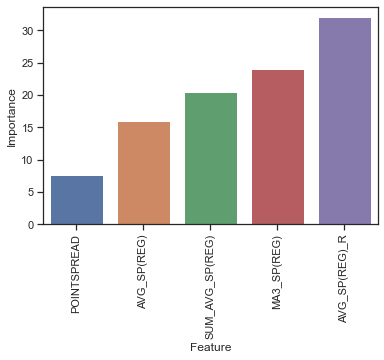

In [18]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [19]:
y_hat = model.predict(X_test)
y_avg = feature_matrix.loc[X_test.index, 'AVG_SP(REG)']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.361
Baseline: -0.079

Mean Absolute Error (Σ|y-pred|/n):
Model: 255.041221
Baseline: 316.694925

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 330.570674
Baseline: 429.545279


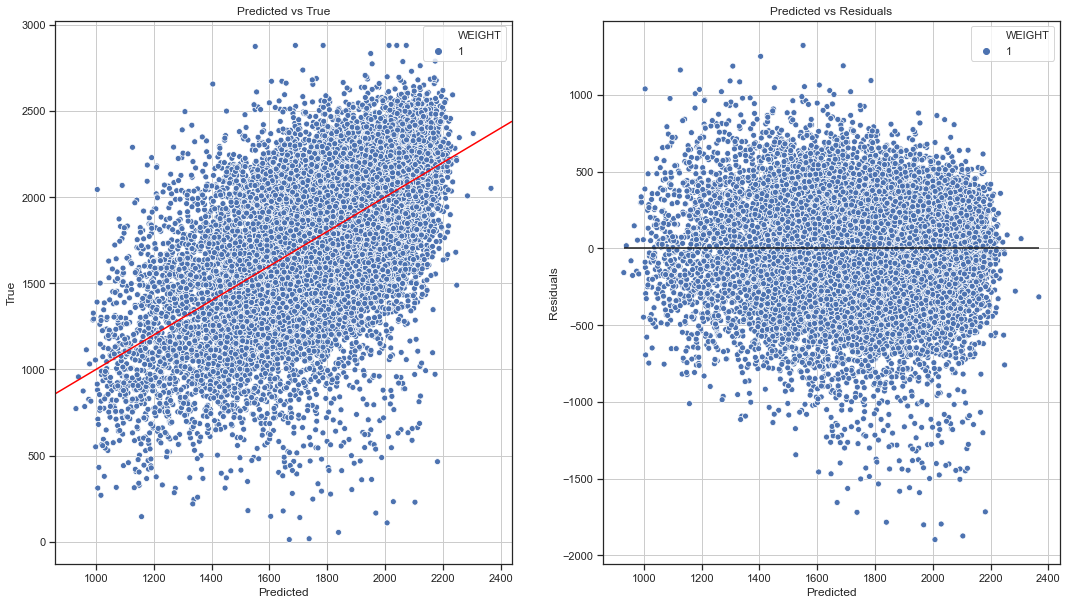

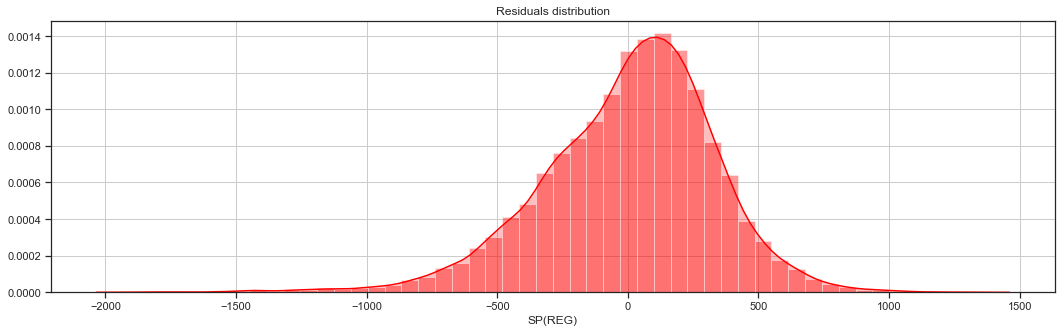

In [20]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

# BENCH PLAYER MODEL

In [21]:
bench_boxscores = boxscores.loc[boxscores['START'] == 0]
bench_regressors = [i for i in regressors if i != 'POINTSPREAD']

feature_matrix = bench_boxscores[['GAMEID', 'PLAYERID'] + bench_regressors + [y] + [w]]
feature_matrix = feature_matrix.dropna(subset=['AVG_SP(REG)'])
feature_matrix['MA3_SP(REG)'] = feature_matrix['MA3_SP(REG)'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['AVG_SP(REG)_R'] = feature_matrix['AVG_SP(REG)_R'].fillna(feature_matrix['AVG_SP(REG)'])

selected_features = bench_regressors
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [22]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['RMSE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 10,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 596.0253808	test: 597.9416165	best: 597.9416165 (0)	total: 8.96ms	remaining: 44.8s
1:	learn: 589.4247270	test: 591.3197927	best: 591.3197927 (1)	total: 16.5ms	remaining: 41.2s
2:	learn: 582.9274096	test: 584.8296327	best: 584.8296327 (2)	total: 22.2ms	remaining: 37s
3:	learn: 576.6029280	test: 578.4730549	best: 578.4730549 (3)	total: 28.8ms	remaining: 36s
4:	learn: 570.4385605	test: 572.3057103	best: 572.3057103 (4)	total: 34.2ms	remaining: 34.1s
5:	learn: 564.4392108	test: 566.3012440	best: 566.3012440 (5)	total: 39.2ms	remaining: 32.6s
6:	learn: 558.6905226	test: 560.5419494	best: 560.5419494 (6)	total: 44ms	remaining: 31.4s
7:	learn: 552.9208068	test: 554.7700906	best: 554.7700906 (7)	total: 49.6ms	remaining: 30.9s
8:	learn: 547.4467416	test: 549.3171500	best: 549.3171500 (8)	total: 55.4ms	remaining: 30.7s
9:	learn: 542.0386352	test: 543.9056356	best: 543.9056356 (9)	total: 60.6ms	remaining: 30.2s
10:	learn: 536.7530324	test: 538.6492504	best: 538.6492504 (10)	total: 65.7m

107:	learn: 379.1246757	test: 380.5486494	best: 380.5486494 (107)	total: 595ms	remaining: 27s
108:	learn: 378.9020249	test: 380.3276929	best: 380.3276929 (108)	total: 602ms	remaining: 27s
109:	learn: 378.6869977	test: 380.1147166	best: 380.1147166 (109)	total: 608ms	remaining: 27s
110:	learn: 378.4691719	test: 379.8928888	best: 379.8928888 (110)	total: 613ms	remaining: 27s
111:	learn: 378.2712866	test: 379.6915053	best: 379.6915053 (111)	total: 618ms	remaining: 27s
112:	learn: 378.0876419	test: 379.5070851	best: 379.5070851 (112)	total: 623ms	remaining: 26.9s
113:	learn: 377.8973493	test: 379.3177323	best: 379.3177323 (113)	total: 628ms	remaining: 26.9s
114:	learn: 377.7159452	test: 379.1315166	best: 379.1315166 (114)	total: 632ms	remaining: 26.9s
115:	learn: 377.5431233	test: 378.9494163	best: 378.9494163 (115)	total: 637ms	remaining: 26.8s
116:	learn: 377.3728230	test: 378.7716336	best: 378.7716336 (116)	total: 642ms	remaining: 26.8s
117:	learn: 377.2014649	test: 378.5991272	best: 37

219:	learn: 371.6782628	test: 373.0548757	best: 373.0548757 (219)	total: 1.18s	remaining: 25.7s
220:	learn: 371.6678547	test: 373.0415272	best: 373.0415272 (220)	total: 1.19s	remaining: 25.7s
221:	learn: 371.6532601	test: 373.0300143	best: 373.0300143 (221)	total: 1.19s	remaining: 25.7s
222:	learn: 371.6395586	test: 373.0160161	best: 373.0160161 (222)	total: 1.2s	remaining: 25.7s
223:	learn: 371.6265446	test: 373.0026373	best: 373.0026373 (223)	total: 1.2s	remaining: 25.7s
224:	learn: 371.6136044	test: 372.9927931	best: 372.9927931 (224)	total: 1.21s	remaining: 25.7s
225:	learn: 371.6013230	test: 372.9800125	best: 372.9800125 (225)	total: 1.21s	remaining: 25.6s
226:	learn: 371.5895349	test: 372.9670799	best: 372.9670799 (226)	total: 1.22s	remaining: 25.6s
227:	learn: 371.5763593	test: 372.9559961	best: 372.9559961 (227)	total: 1.22s	remaining: 25.6s
228:	learn: 371.5641424	test: 372.9453671	best: 372.9453671 (228)	total: 1.23s	remaining: 25.6s
229:	learn: 371.5526932	test: 372.9340228	

327:	learn: 370.8045794	test: 372.3721400	best: 372.3721400 (327)	total: 1.76s	remaining: 25.1s
328:	learn: 370.8007199	test: 372.3694849	best: 372.3694849 (328)	total: 1.77s	remaining: 25.2s
329:	learn: 370.7934425	test: 372.3637407	best: 372.3637407 (329)	total: 1.78s	remaining: 25.2s
330:	learn: 370.7835631	test: 372.3565497	best: 372.3565497 (330)	total: 1.78s	remaining: 25.1s
331:	learn: 370.7749069	test: 372.3526136	best: 372.3526136 (331)	total: 1.79s	remaining: 25.1s
332:	learn: 370.7697646	test: 372.3495200	best: 372.3495200 (332)	total: 1.79s	remaining: 25.1s
333:	learn: 370.7625209	test: 372.3486291	best: 372.3486291 (333)	total: 1.8s	remaining: 25.1s
334:	learn: 370.7542741	test: 372.3483083	best: 372.3483083 (334)	total: 1.8s	remaining: 25.1s
335:	learn: 370.7496912	test: 372.3465547	best: 372.3465547 (335)	total: 1.81s	remaining: 25.1s
336:	learn: 370.7424351	test: 372.3437546	best: 372.3437546 (336)	total: 1.81s	remaining: 25.1s
337:	learn: 370.7380075	test: 372.3412060	

415:	learn: 370.3404293	test: 372.1570402	best: 372.1561012 (414)	total: 2.35s	remaining: 25.9s
416:	learn: 370.3386682	test: 372.1567519	best: 372.1561012 (414)	total: 2.36s	remaining: 25.9s
417:	learn: 370.3329989	test: 372.1549864	best: 372.1549864 (417)	total: 2.37s	remaining: 25.9s
418:	learn: 370.3302813	test: 372.1535491	best: 372.1535491 (418)	total: 2.37s	remaining: 25.9s
419:	learn: 370.3266108	test: 372.1498836	best: 372.1498836 (419)	total: 2.38s	remaining: 25.9s
420:	learn: 370.3232345	test: 372.1499926	best: 372.1498836 (419)	total: 2.38s	remaining: 25.9s
421:	learn: 370.3154094	test: 372.1450195	best: 372.1450195 (421)	total: 2.39s	remaining: 25.9s
422:	learn: 370.3106636	test: 372.1435799	best: 372.1435799 (422)	total: 2.39s	remaining: 25.9s
423:	learn: 370.3082605	test: 372.1412751	best: 372.1412751 (423)	total: 2.4s	remaining: 25.9s
424:	learn: 370.3035476	test: 372.1380759	best: 372.1380759 (424)	total: 2.4s	remaining: 25.9s
425:	learn: 370.2967314	test: 372.1350850	

519:	learn: 369.8530025	test: 372.0182286	best: 372.0182286 (519)	total: 2.95s	remaining: 25.4s
520:	learn: 369.8503135	test: 372.0181242	best: 372.0181242 (520)	total: 2.96s	remaining: 25.4s
521:	learn: 369.8442371	test: 372.0186321	best: 372.0181242 (520)	total: 2.96s	remaining: 25.4s
522:	learn: 369.8406506	test: 372.0171530	best: 372.0171530 (522)	total: 2.98s	remaining: 25.5s
523:	learn: 369.8360103	test: 372.0164734	best: 372.0164734 (523)	total: 2.98s	remaining: 25.5s
524:	learn: 369.8308171	test: 372.0170639	best: 372.0164734 (523)	total: 3s	remaining: 25.5s
525:	learn: 369.8256454	test: 372.0158582	best: 372.0158582 (525)	total: 3s	remaining: 25.6s
526:	learn: 369.8207764	test: 372.0155187	best: 372.0155187 (526)	total: 3.01s	remaining: 25.6s
527:	learn: 369.8173431	test: 372.0150907	best: 372.0150907 (527)	total: 3.02s	remaining: 25.5s
528:	learn: 369.8149574	test: 372.0146660	best: 372.0146660 (528)	total: 3.02s	remaining: 25.5s
529:	learn: 369.8102067	test: 372.0140410	best

623:	learn: 369.3747466	test: 371.9149700	best: 371.9149700 (623)	total: 3.55s	remaining: 24.9s
624:	learn: 369.3720473	test: 371.9132080	best: 371.9132080 (624)	total: 3.56s	remaining: 24.9s
625:	learn: 369.3695339	test: 371.9102448	best: 371.9102448 (625)	total: 3.56s	remaining: 24.9s
626:	learn: 369.3646769	test: 371.9083904	best: 371.9083904 (626)	total: 3.57s	remaining: 24.9s
627:	learn: 369.3580196	test: 371.9059951	best: 371.9059951 (627)	total: 3.58s	remaining: 24.9s
628:	learn: 369.3555109	test: 371.9024998	best: 371.9024998 (628)	total: 3.59s	remaining: 24.9s
629:	learn: 369.3514238	test: 371.9034457	best: 371.9024998 (628)	total: 3.59s	remaining: 24.9s
630:	learn: 369.3460161	test: 371.9012820	best: 371.9012820 (630)	total: 3.6s	remaining: 24.9s
631:	learn: 369.3409094	test: 371.8986005	best: 371.8986005 (631)	total: 3.6s	remaining: 24.9s
632:	learn: 369.3356573	test: 371.8987238	best: 371.8986005 (631)	total: 3.61s	remaining: 24.9s
633:	learn: 369.3309360	test: 371.8982854	

730:	learn: 368.8299054	test: 371.7985309	best: 371.7985309 (730)	total: 4.14s	remaining: 24.2s
731:	learn: 368.8251903	test: 371.7985227	best: 371.7985227 (731)	total: 4.14s	remaining: 24.2s
732:	learn: 368.8226709	test: 371.7991906	best: 371.7985227 (731)	total: 4.15s	remaining: 24.2s
733:	learn: 368.8154877	test: 371.7989327	best: 371.7985227 (731)	total: 4.16s	remaining: 24.2s
734:	learn: 368.8086312	test: 371.7969484	best: 371.7969484 (734)	total: 4.16s	remaining: 24.1s
735:	learn: 368.8048913	test: 371.7952974	best: 371.7952974 (735)	total: 4.16s	remaining: 24.1s
736:	learn: 368.7974286	test: 371.7955148	best: 371.7952974 (735)	total: 4.17s	remaining: 24.1s
737:	learn: 368.7897650	test: 371.7940494	best: 371.7940494 (737)	total: 4.17s	remaining: 24.1s
738:	learn: 368.7840823	test: 371.7904406	best: 371.7904406 (738)	total: 4.18s	remaining: 24.1s
739:	learn: 368.7785854	test: 371.7897190	best: 371.7897190 (739)	total: 4.19s	remaining: 24.1s
740:	learn: 368.7731694	test: 371.785889

In [23]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

0:	learn: 596.0253808	test: 597.9416165	best: 597.9416165 (0)	total: 12.1ms	remaining: 1m
1:	learn: 589.4247270	test: 591.3197927	best: 591.3197927 (1)	total: 17.4ms	remaining: 43.5s
2:	learn: 582.9274096	test: 584.8296327	best: 584.8296327 (2)	total: 23.2ms	remaining: 38.6s
3:	learn: 576.6029280	test: 578.4730549	best: 578.4730549 (3)	total: 27.9ms	remaining: 34.9s
4:	learn: 570.4385605	test: 572.3057103	best: 572.3057103 (4)	total: 32.8ms	remaining: 32.8s
5:	learn: 564.4392108	test: 566.3012440	best: 566.3012440 (5)	total: 37.8ms	remaining: 31.5s
6:	learn: 558.6905226	test: 560.5419494	best: 560.5419494 (6)	total: 42.7ms	remaining: 30.4s
7:	learn: 552.9208068	test: 554.7700906	best: 554.7700906 (7)	total: 47.4ms	remaining: 29.6s
8:	learn: 547.4467416	test: 549.3171500	best: 549.3171500 (8)	total: 56.6ms	remaining: 31.4s
9:	learn: 542.0386352	test: 543.9056356	best: 543.9056356 (9)	total: 70.1ms	remaining: 35s
10:	learn: 536.7530324	test: 538.6492504	best: 538.6492504 (10)	total: 78.5

95:	learn: 382.4582244	test: 383.9375765	best: 383.9375765 (95)	total: 600ms	remaining: 30.6s
96:	learn: 382.1332923	test: 383.6093948	best: 383.6093948 (96)	total: 607ms	remaining: 30.7s
97:	learn: 381.8167823	test: 383.2891430	best: 383.2891430 (97)	total: 621ms	remaining: 31.1s
98:	learn: 381.4954460	test: 382.9597579	best: 382.9597579 (98)	total: 632ms	remaining: 31.3s
99:	learn: 381.1984463	test: 382.6610517	best: 382.6610517 (99)	total: 637ms	remaining: 31.2s
100:	learn: 380.9019599	test: 382.3665686	best: 382.3665686 (100)	total: 641ms	remaining: 31.1s
101:	learn: 380.6379399	test: 382.0990746	best: 382.0990746 (101)	total: 654ms	remaining: 31.4s
102:	learn: 380.3612194	test: 381.8146752	best: 381.8146752 (102)	total: 660ms	remaining: 31.4s
103:	learn: 380.0933800	test: 381.5407696	best: 381.5407696 (103)	total: 665ms	remaining: 31.3s
104:	learn: 379.8470186	test: 381.2896669	best: 381.2896669 (104)	total: 670ms	remaining: 31.2s
105:	learn: 379.5942530	test: 381.0386834	best: 38

195:	learn: 372.0994549	test: 373.4287505	best: 373.4287505 (195)	total: 1.18s	remaining: 28.8s
196:	learn: 372.0791949	test: 373.4097049	best: 373.4097049 (196)	total: 1.19s	remaining: 29s
197:	learn: 372.0571453	test: 373.3895681	best: 373.3895681 (197)	total: 1.19s	remaining: 29s
198:	learn: 372.0357746	test: 373.3720422	best: 373.3720422 (198)	total: 1.2s	remaining: 29s
199:	learn: 372.0165623	test: 373.3550723	best: 373.3550723 (199)	total: 1.2s	remaining: 28.9s
200:	learn: 371.9903893	test: 373.3349949	best: 373.3349949 (200)	total: 1.21s	remaining: 28.9s
201:	learn: 371.9735778	test: 373.3212673	best: 373.3212673 (201)	total: 1.21s	remaining: 28.8s
202:	learn: 371.9573634	test: 373.3058268	best: 373.3058268 (202)	total: 1.22s	remaining: 28.8s
203:	learn: 371.9403718	test: 373.2915328	best: 373.2915328 (203)	total: 1.22s	remaining: 28.8s
204:	learn: 371.9173161	test: 373.2733353	best: 373.2733353 (204)	total: 1.23s	remaining: 28.8s
205:	learn: 371.9020178	test: 373.2580016	best: 

296:	learn: 370.9968406	test: 372.4808971	best: 372.4808971 (296)	total: 1.76s	remaining: 28s
297:	learn: 370.9897133	test: 372.4749979	best: 372.4749979 (297)	total: 1.77s	remaining: 27.9s
298:	learn: 370.9802003	test: 372.4708887	best: 372.4708887 (298)	total: 1.78s	remaining: 27.9s
299:	learn: 370.9748515	test: 372.4680643	best: 372.4680643 (299)	total: 1.78s	remaining: 27.9s
300:	learn: 370.9665506	test: 372.4667906	best: 372.4667906 (300)	total: 1.78s	remaining: 27.9s
301:	learn: 370.9611162	test: 372.4638489	best: 372.4638489 (301)	total: 1.79s	remaining: 27.8s
302:	learn: 370.9555497	test: 372.4599241	best: 372.4599241 (302)	total: 1.79s	remaining: 27.8s
303:	learn: 370.9481948	test: 372.4569765	best: 372.4569765 (303)	total: 1.8s	remaining: 27.8s
304:	learn: 370.9424428	test: 372.4538346	best: 372.4538346 (304)	total: 1.8s	remaining: 27.8s
305:	learn: 370.9356761	test: 372.4520273	best: 372.4520273 (305)	total: 1.81s	remaining: 27.8s
306:	learn: 370.9322323	test: 372.4474510	be

405:	learn: 370.3818205	test: 372.1795191	best: 372.1795191 (405)	total: 2.34s	remaining: 26.5s
406:	learn: 370.3783995	test: 372.1771195	best: 372.1771195 (406)	total: 2.35s	remaining: 26.5s
407:	learn: 370.3736170	test: 372.1732086	best: 372.1732086 (407)	total: 2.35s	remaining: 26.5s
408:	learn: 370.3711105	test: 372.1715199	best: 372.1715199 (408)	total: 2.36s	remaining: 26.5s
409:	learn: 370.3664466	test: 372.1689550	best: 372.1689550 (409)	total: 2.36s	remaining: 26.5s
410:	learn: 370.3630486	test: 372.1654772	best: 372.1654772 (410)	total: 2.37s	remaining: 26.4s
411:	learn: 370.3578738	test: 372.1623437	best: 372.1623437 (411)	total: 2.37s	remaining: 26.4s
412:	learn: 370.3539065	test: 372.1608199	best: 372.1608199 (412)	total: 2.38s	remaining: 26.4s
413:	learn: 370.3507493	test: 372.1584052	best: 372.1584052 (413)	total: 2.38s	remaining: 26.4s
414:	learn: 370.3452774	test: 372.1561012	best: 372.1561012 (414)	total: 2.39s	remaining: 26.4s
415:	learn: 370.3404293	test: 372.157040

509:	learn: 369.8979817	test: 372.0295991	best: 372.0295991 (509)	total: 2.92s	remaining: 25.8s
510:	learn: 369.8928842	test: 372.0285442	best: 372.0285442 (510)	total: 2.93s	remaining: 25.8s
511:	learn: 369.8880385	test: 372.0276485	best: 372.0276485 (511)	total: 2.94s	remaining: 25.8s
512:	learn: 369.8848793	test: 372.0258697	best: 372.0258697 (512)	total: 2.94s	remaining: 25.8s
513:	learn: 369.8781505	test: 372.0249539	best: 372.0249539 (513)	total: 2.95s	remaining: 25.7s
514:	learn: 369.8727936	test: 372.0228499	best: 372.0228499 (514)	total: 2.96s	remaining: 25.7s
515:	learn: 369.8674153	test: 372.0226484	best: 372.0226484 (515)	total: 2.96s	remaining: 25.8s
516:	learn: 369.8641681	test: 372.0223341	best: 372.0223341 (516)	total: 2.97s	remaining: 25.8s
517:	learn: 369.8607920	test: 372.0197631	best: 372.0197631 (517)	total: 2.98s	remaining: 25.8s
518:	learn: 369.8569533	test: 372.0187109	best: 372.0187109 (518)	total: 2.99s	remaining: 25.8s
519:	learn: 369.8530025	test: 372.018228

596:	learn: 369.4946942	test: 371.9424733	best: 371.9416100 (591)	total: 3.48s	remaining: 25.7s
597:	learn: 369.4898595	test: 371.9426187	best: 371.9416100 (591)	total: 3.49s	remaining: 25.7s
598:	learn: 369.4840775	test: 371.9424382	best: 371.9416100 (591)	total: 3.5s	remaining: 25.7s
599:	learn: 369.4797272	test: 371.9422332	best: 371.9416100 (591)	total: 3.5s	remaining: 25.7s
600:	learn: 369.4760644	test: 371.9415428	best: 371.9415428 (600)	total: 3.51s	remaining: 25.7s
601:	learn: 369.4721648	test: 371.9382404	best: 371.9382404 (601)	total: 3.51s	remaining: 25.7s
602:	learn: 369.4696065	test: 371.9372038	best: 371.9372038 (602)	total: 3.52s	remaining: 25.7s
603:	learn: 369.4672295	test: 371.9357201	best: 371.9357201 (603)	total: 3.52s	remaining: 25.6s
604:	learn: 369.4640960	test: 371.9334892	best: 371.9334892 (604)	total: 3.53s	remaining: 25.6s
605:	learn: 369.4587007	test: 371.9333087	best: 371.9333087 (605)	total: 3.53s	remaining: 25.6s
606:	learn: 369.4534370	test: 371.9324680	

699:	learn: 368.9914787	test: 371.8352781	best: 371.8352781 (699)	total: 4.08s	remaining: 25.1s
700:	learn: 368.9883112	test: 371.8345460	best: 371.8345460 (700)	total: 4.09s	remaining: 25.1s
701:	learn: 368.9845320	test: 371.8353394	best: 371.8345460 (700)	total: 4.09s	remaining: 25.1s
702:	learn: 368.9780023	test: 371.8342162	best: 371.8342162 (702)	total: 4.1s	remaining: 25.1s
703:	learn: 368.9739110	test: 371.8332336	best: 371.8332336 (703)	total: 4.11s	remaining: 25.1s
704:	learn: 368.9696046	test: 371.8328798	best: 371.8328798 (704)	total: 4.12s	remaining: 25.1s
705:	learn: 368.9635537	test: 371.8294706	best: 371.8294706 (705)	total: 4.12s	remaining: 25.1s
706:	learn: 368.9570497	test: 371.8286358	best: 371.8286358 (706)	total: 4.13s	remaining: 25.1s
707:	learn: 368.9470539	test: 371.8265854	best: 371.8265854 (707)	total: 4.13s	remaining: 25.1s
708:	learn: 368.9411560	test: 371.8237381	best: 371.8237381 (708)	total: 4.14s	remaining: 25s
709:	learn: 368.9332474	test: 371.8235165	b

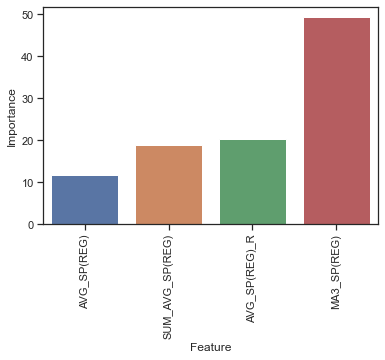

In [24]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [25]:
y_hat = model.predict(X_test)
y_avg = feature_matrix.loc[X_test.index, 'AVG_SP(REG)']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.622
Baseline: 0.482

Mean Absolute Error (Σ|y-pred|/n):
Model: 287.064709
Baseline: 332.758569

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 371.774983
Baseline: 435.12881


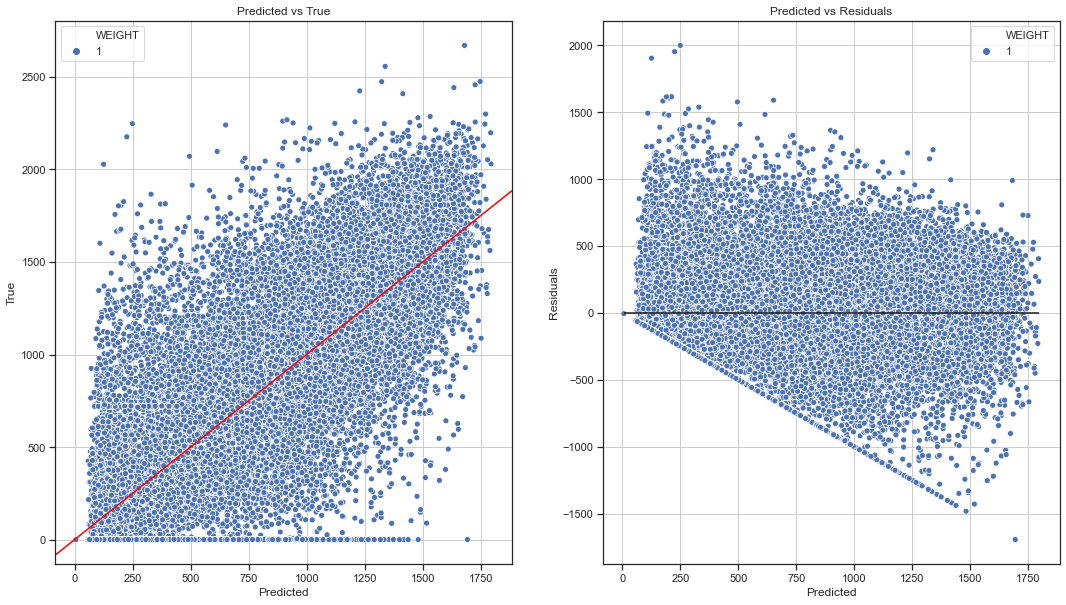

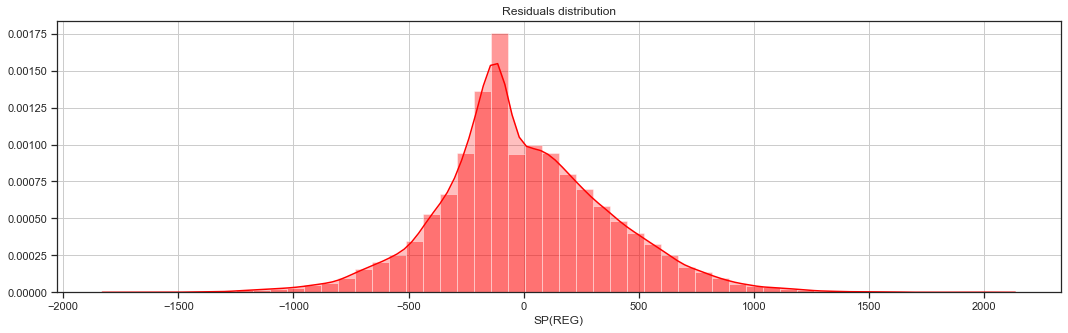

In [26]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [27]:
print(regressors)
print(bench_regressors)

['AVG_SP(REG)', 'MA3_SP(REG)', 'AVG_SP(REG)_R', 'SUM_AVG_SP(REG)', 'POINTSPREAD']
['AVG_SP(REG)', 'MA3_SP(REG)', 'AVG_SP(REG)_R', 'SUM_AVG_SP(REG)']
